<a href="https://colab.research.google.com/github/kurexi/fml-labs/blob/main/FML_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Non parametric and Ensumble Methods
## Part 1: k-Nearst Neighbors and the Curce of Dimensionality
### Step 1: Load and Prepare the Data

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Origianl feature dimension: {X_train.shape[1]}")

Origianl feature dimension: 64


### Step 2: kNN on Low-Dimensional Data (64 Dimensions)

In [46]:
test_size = X_test.shape[0]
train_size = X_train.shape[0]

def custom_knn(k, X_train, y_train, X_test):
  test_size = X_test.shape[0]
  train_size = X_train.shape[0]

  predictions = np.zeros(test_size)

  # Each test set
  for i in range(test_size):
    test_sample = X_test[i]
    distances = np.ones(k) * (2^63 - 1)
    index_of_samples = [0] * k

    # Eeach training set
    for j in range(train_size):
      sample = X_train[j]
      distance = np.linalg.norm(test_sample - sample)

      # find the posision of max and replace it
      max_position = 0
      for d in range(k):
        if distances[d] > distances[max_position]:
          max_position = d

      if distances[max_position] > distance:
        distances[max_position] = distance
        index_of_samples[max_position] = j

    # find majority
    counts = {}
    for j in index_of_samples:
      class_ = y_train[j]
      if not class_ in counts.keys():
        counts[class_] = 0
      counts[class_] += 1

    max = 0;
    for class_ in counts.keys():
      count = counts[class_]
      if count > max:
        max = count
        predictions[i] = class_

  return predictions

# prediction
predictions = custom_knn(5, X_train, y_train, X_test)

# Model evaluation
def classification_evaluation(y_truth, y_predict):
  true_predictions = y_predict[y_predict == y_truth]
  accuracy = true_predictions.size / y_predict.size
  print(f"Accuracy {accuracy}")

classification_evaluation(y_test, predictions)

Accuracy 0.9907407407407407


### Step 3: Adding Noisy Features to Create a High-Dimensional Dataset

In [47]:
# Define the number of noise features to add
n_noise_features = 10000

# Generate random noise for the training set
noise_train = 10 * np.random.rand(X_train.shape[0], n_noise_features)
# Concatenate the origianl features with the noise
X_train_high_dim = np.concatenate([X_train, noise_train], axis=1)

# Generate random noise for the test set
noise_test = 10 * np.random.rand(X_test.shape[0], n_noise_features)
# Concatenate the original features with the noise
X_test_high_dim = np.concatenate([X_test, noise_test], axis=1)

print(f"New high-dimensional feature space: {X_train_high_dim.shape[1]}")

New high-dimensional feature space: 10064


### Step 4: kNN on High-Dimensional Data

In [48]:
predictions_high_dim = custom_knn(5, X_train_high_dim, y_train, X_test_high_dim)
classification_evaluation(y_test, predictions_high_dim)

Accuracy 0.07962962962962963


## Part 2: Random Forest - Variance Reduction and Feature Imprtance
### Step 1: Load and Prepare the Data

In [49]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier

# Lead breast canser dataset
cancer = load_breast_cancer()

X_cancer, y_cancer = cancer.data, cancer.target
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, random_state=42
)

### Step 2: Analyze the Effect of the Number of Trees


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

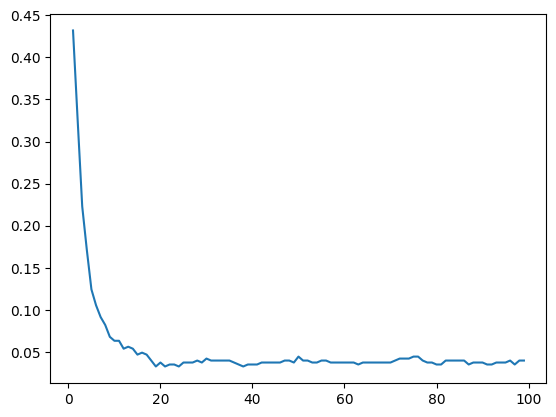

In [50]:
n_estimators_range = list(range(1, 100))

oob_scores = np.zeros(len(n_estimators_range))
for i in range(len(n_estimators_range)):
  n_estimators = n_estimators_range[i]
  rfc = RandomForestClassifier(n_estimators, random_state=42, oob_score=True)
  rfc.fit(X_train_cancer, y_train_cancer)
  oob_scores[i] = 1 - rfc.oob_score_

plt.plot(n_estimators_range, oob_scores)

In [51]:
1- oob_scores[20:].sum() / oob_scores[20:].size

np.float64(0.9618470315564271)

### Step 3: Identify Feature Importance

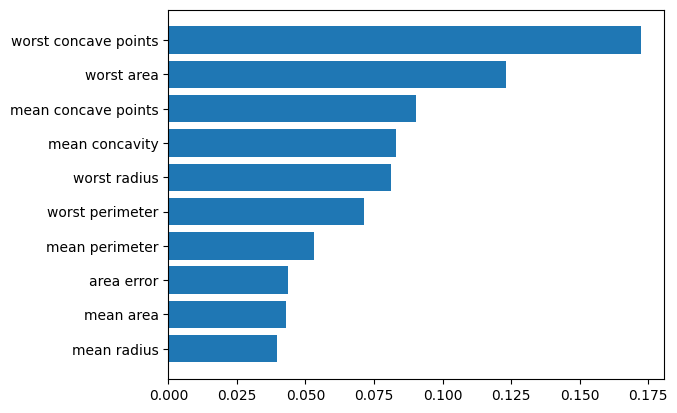

In [52]:
from collections.abc import Sequence
rfc = RandomForestClassifier(100, random_state=42, oob_score=True)
rfc.fit(X_train_cancer, y_train_cancer)

def plot_feature_importance(cancer_data, feature_importances, top_n=10):
  labeles = [(cancer_data.feature_names[i], feature_importances[i]) for i in range(len(cancer_data.feature_names))]
  labeles.sort(key=lambda x:x[1])
  labeles = labeles[-top_n:]

  plt.barh([label[0] for label in labeles], [label[1] for label in labeles])
  plt.show()

plot_feature_importance(cancer, rfc.feature_importances_)

## Part 3: Visualizing the AdaBoost Re-weighting Process
### Step 1: Load and Prepare the Data

In [53]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris();
X = iris.data[:, [0, 2]]
y = iris.target
X_ab, y_ab = X[y != 0], y[y != 0]
y_ab[y_ab == 1] = -1
y_ab[y_ab == 2] = 1

### Step 2: Implement the AdaBoost Iterations


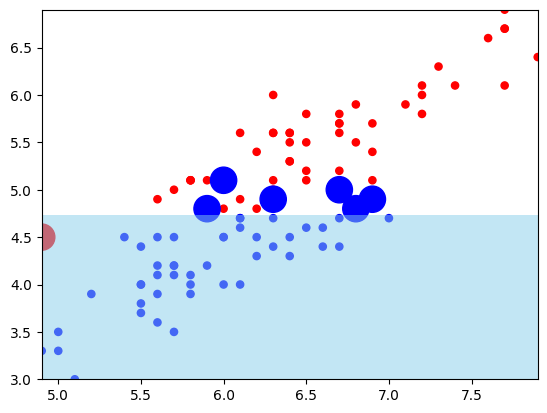

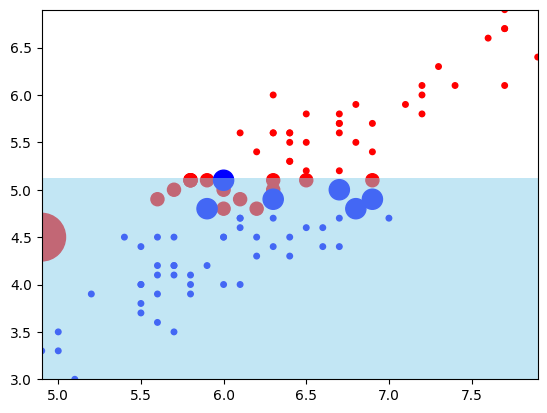

In [54]:
# Initialize weights
n_samples = X_ab.shape[0]
sample_weights = np.full(n_samples, (1 / n_samples))

def plot_the_decision_boundary(model, X_train, y, sample_weights):
  """
  We know the previous info that, there are only two features
  """

  group_a = X_train[y == 1]
  group_b = X_train[y != 1]
  weight_a = sample_weights[y==1]
  weight_a = weight_a * float(sample_weights.size) * 50;
  weight_b = sample_weights[y!=1]
  weight_b = weight_b * float(sample_weights.size) * 50;

  plt.scatter(group_a[:,0], group_a[:,1], s=weight_a, color='r')
  plt.scatter(group_b[:,0], group_b[:,1], s=weight_b,color='b')

  x_vec = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
  y_vec = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
  X, Y = np.meshgrid(x_vec, y_vec)
  Z = np.zeros(X.shape)

  # y axies
  if model.tree_.feature[0] == 1:
    boundary = model.tree_.threshold[0]
    Z[Y > boundary] = 1
    #plt.hlines(boundary, X_train[:, 0].min(), X_train[:, 0].max())
    plt.contourf(X, Y, Z, levels=[-1, 0], colors=['skyblue'], alpha=0.5)
  # x axies
  else:
    boundary = model.tree_.threshold[0]
    Z[X > boundary] = 1
    #plt.vlines(boundary, X_train[:, 1].min(), X_train[:, 1].max())
    plt.contourf(X, Y, Z, levels=[-1, 0], colors=['skyblue'], alpha=0.5)
  plt.show()

def iteration(X_train, y_train, sample_weights):
  """
  Iteration of AdaBoost
  """
  dtc = DecisionTreeClassifier(max_depth=1, random_state=42);
  dtc.fit(X_train, y_train, sample_weight=sample_weights);
  predict = dtc.predict(X_train)

  misclassfied = np.zeros(n_samples)

  # misclassfied points
  misclassfied[predict != y_ab] = 1

  # classified points
  misclassfied[predict == y_ab] = 0

  # due to weights are normalized, this should just be sum of missclassfied weighte
  error = (sample_weights * misclassfied).sum()
  alpha = np.log((1-error)/error)/2

  # update weights
  sample_weights = sample_weights * np.exp(-alpha*y_ab*predict)

  # normalize weights
  sample_weights = sample_weights / sample_weights.sum()

  return dtc, predict, sample_weights

t = 2
m = None
for i in range(t):
  m, predict, sample_weights = iteration(X_ab, y_ab, sample_weights)
  plot_the_decision_boundary(m, X_ab, y_ab, sample_weights)

## Part 4: Gradient Boostirng with XGBoost
### Step 1: Install XGBoost

In [55]:
!pip install xgboost

### Step 2: Train and Evaluate an XGBoost Classifier

In [56]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb_model = xgb.XGBClassifier(Objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

xgb_model.fit(X_train_cancer, y_train_cancer)

y_pred_xgb = xgb_model.predict(X_test_cancer)
print("--- XGBoost Classification Report ---")
print(classification_report(y_test_cancer, y_pred_xgb))

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        54
           1       0.97      0.98      0.97        89

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:02:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "Objective", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Step3: Analyze XGBoost feature Importance

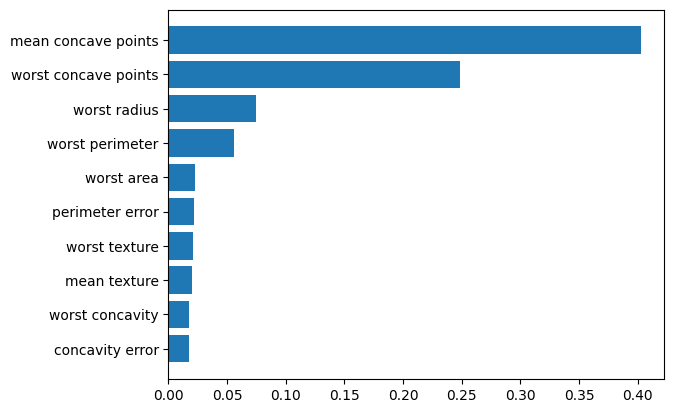

In [57]:
plot_feature_importance(cancer, xgb_model.feature_importances_)